In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# Read in data
df = pd.read_csv('amazon_alexa.tsv',delimiter='\t',quoting=3)
print(df.shape)
df = df.head(500)
print(df.shape)
df.head()

(3150, 5)
(500, 5)


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [3]:
df.isnull().sum()
# There is one record in reviews which is null

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [4]:
df[df['verified_reviews'].isna()]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [5]:
df.dropna(inplace=True)

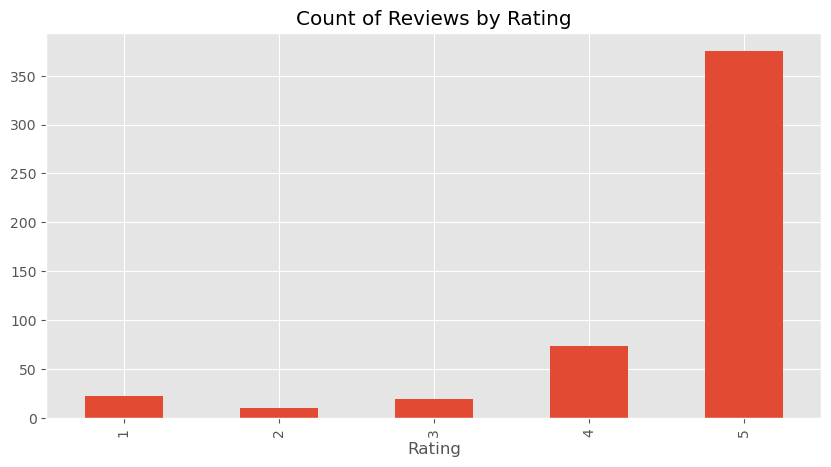

In [6]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Rating',
          figsize=(10, 5))
ax.set_xlabel('Rating')
plt.show()

### Basic NLK

In [7]:
example = df['verified_reviews'][51]
print(example)

"I'm still learning how to use it, but so far my Echo is great! The sound is actually much better than I was expecting."


In [8]:
# Test with a simple string
tokens = nltk.word_tokenize(example)
print("Test tokens:", tokens)

Test tokens: ['``', 'I', "'m", 'still', 'learning', 'how', 'to', 'use', 'it', ',', 'but', 'so', 'far', 'my', 'Echo', 'is', 'great', '!', 'The', 'sound', 'is', 'actually', 'much', 'better', 'than', 'I', 'was', 'expecting', '.', "''"]


In [9]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('``', '``'),
 ('I', 'PRP'),
 ("'m", 'VBP'),
 ('still', 'RB'),
 ('learning', 'VBG'),
 ('how', 'WRB'),
 ('to', 'TO'),
 ('use', 'VB'),
 ('it', 'PRP'),
 (',', ',')]

In [10]:
entities = nltk.chunk.ne_chunk(tagged)

entities.pprint()

(S
  ``/``
  I/PRP
  'm/VBP
  still/RB
  learning/VBG
  how/WRB
  to/TO
  use/VB
  it/PRP
  ,/,
  but/CC
  so/RB
  far/RB
  my/PRP$
  Echo/NNP
  is/VBZ
  great/JJ
  !/.
  The/DT
  sound/NN
  is/VBZ
  actually/RB
  much/JJ
  better/JJR
  than/IN
  I/PRP
  was/VBD
  expecting/VBG
  ./.
  ''/'')


### VADER Seniment Scoring


(Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach  
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.  

This uses a "bag of words" approach:  
Stop words are removed  
each word is scored and combined to a total score.  

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [12]:
sia.polarity_scores("Never could get it to work. A techie friend looked at it for me and said the adapter wasn't strong enough to power it and that it looked like it had been bought at a dollar store. So, I am going to replace the adapter and hope it works then")

{'neg': 0.05, 'neu': 0.792, 'pos': 0.158, 'compound': 0.7094}

In [13]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.682, 'pos': 0.318, 'compound': 0.8955}

In [14]:
sentiment_scores = df['verified_reviews'].apply(lambda x: sia.polarity_scores(x)).apply(pd.Series)
df = pd.concat([df, sentiment_scores], axis=1)

df

,rating,date,variation,verified_reviews,feedback,neg,neu,pos,compound
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,0.000,0.308,0.692,0.6696
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,0.000,0.193,0.807,0.6360
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,0.102,0.784,0.114,-0.1280
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,0.000,0.670,0.330,0.8957
4,5,31-Jul-18,Charcoal Fabric,Music,1,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...
495,5,25-Jun-18,Black,"""I love Alexa! It's great helping me, making m...",1,0.000,0.539,0.461,0.9370
496,5,25-Jun-18,Black,Got this for the bathroom love it we can liste...,1,0.000,0.756,0.244,0.6369
497,5,25-Jun-18,Black,I have 3-Dots and 2-Original and this new one ...,1,0.000,0.792,0.208,0.6369
498,4,25-Jun-18,Black,Was a little hard to get it to pare up with th...,1,0.303,0.697,0.000,-0.7509


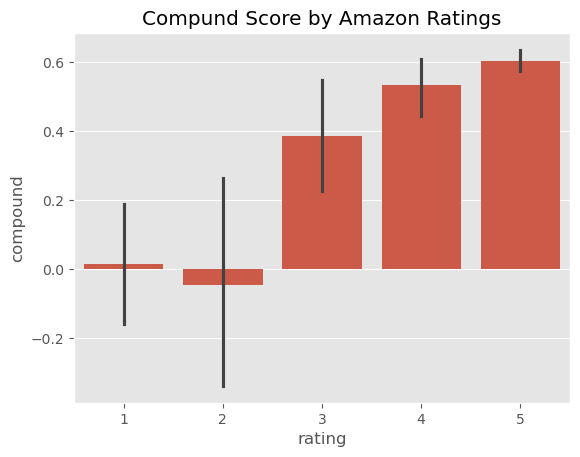

In [15]:
ax = sns.barplot(data=df, x='rating', y='compound')
ax.set_title('Compund Score by Amazon Ratings')
plt.show()

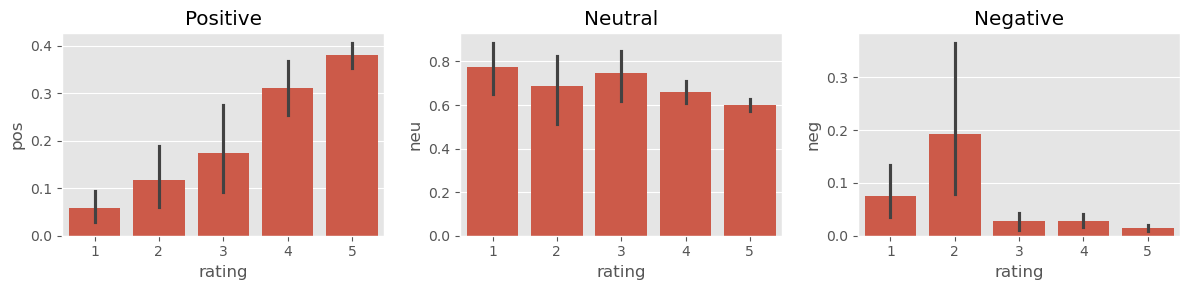

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x='rating', y='pos', ax=axs[0])
sns.barplot(data=df, x='rating', y='neu', ax=axs[1])
sns.barplot(data=df, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [17]:
def sentiment_label(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['compound'].apply(sentiment_label)

In [18]:
def tag_mismatch(row):
    if row['rating'] in [1, 2] and row['sentiment_label'] == 'Positive':
        return True
    elif row['rating'] in [4, 5] and row['sentiment_label'] == 'Negative':
        return True
    elif row['sentiment_label'] == 'Neutral' and row['rating'] != 3:
        return True
    else:
        return False

df['mismatch'] = df.apply(tag_mismatch, axis=1)

df[df['mismatch']][['verified_reviews', 'feedback', 'compound', 'sentiment_label','rating']]



,verified_reviews,feedback,compound,sentiment_label,rating
2,"""Sometimes while playing a game, you can answe...",1,-0.1280,Negative,4
4,Music,1,0.0000,Neutral,5
10,"""I sent it to my 85 year old Dad, and he talks...",1,0.0000,Neutral,5
14,Just what I expected....,1,0.0000,Neutral,5
46,"""It's like Siri, in fact, Siri answers more ac...",0,0.7351,Positive,2
...,...,...,...,...,...
479,of course!,1,0.0000,Neutral,5
483,Same as new,1,0.0000,Neutral,5
491,I've already returned it.,0,0.0000,Neutral,1
498,Was a little hard to get it to pare up with th...,1,-0.7509,Negative,4


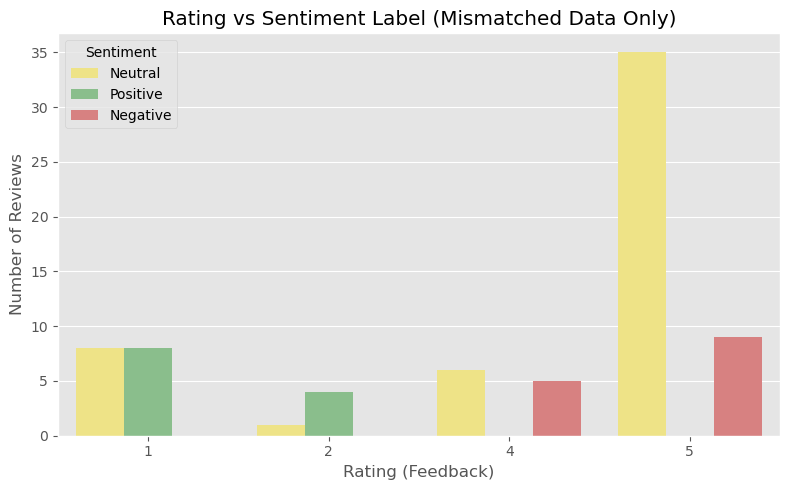

In [19]:
# Filter mismatched rows
mismatch_df = df[df['mismatch']]

# Define custom light colors
custom_palette = {
    'Positive': '#81c784',  # Soft green
    'Negative': '#e57373',  # Soft red
    'Neutral': '#fff176'    # Soft yellow
}

# Plot
plt.figure(figsize=(8, 5))
sns.countplot(data=mismatch_df, x='rating', hue='sentiment_label', palette=custom_palette)

plt.title('Rating vs Sentiment Label (Mismatched Data Only)')
plt.xlabel('Rating (Feedback)')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()